## 1.Problem Definition

The goal of this project is to develop a Machine Learning (ML) model that can classify job postings as "Real" or "Fake" based solely on the job description. The model will analyze the textual content of job descriptions to identify patterns and linguistic markers that differentiate genuine job listings from fraudulent ones.

## Import Required Libraries

In [1]:
# Import essential libraries
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import warnings

from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#from xgboost import XGBClassifier#

# Suppress warnings
warnings.filterwarnings('ignore')


##  Data Loading 

We'll load your dataset using pandas and take a look at the first few rows to understand its structure.

In [2]:
df = pd.read_csv('fake_job_postings.csv')

In [3]:
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                               

In [4]:
# Drop unnecessary columns: job_id and salary_range
df = df.drop(['job_id', 'salary_range'], axis=1)

In [5]:
# Check missing values per column
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
title                      0
location                 346
department             11547
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


In [6]:
# List of text columns to fill with ''
text_columns = ['title', 'location', 'department', 'company_profile',
                'description', 'requirements', 'benefits']

df[text_columns] = df[text_columns].fillna('')


In [7]:
# Check missing values per column
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
title                     0
location                  0
department                0
company_profile           0
description               0
requirements              0
benefits                  0
telecommuting             0
has_company_logo          0
has_questions             0
employment_type        3471
required_experience    7050
required_education     8105
industry               4903
function               6455
fraudulent                0
dtype: int64


In [8]:
# Merge all text features into a single column
df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + ' ' + \
             df['company_profile'] + ' ' + df['description'] + ' ' + \
             df['requirements'] + ' ' + df['benefits']


In [9]:
print(df['text'].head(1).values[0][:500])  # Print first 500 characters of first row

Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented


## Exploratory Data Analysis (EDA)

##  Feature Extraction & Data Splitting

In [10]:
# Features and target
X = df['text']  # the merged text column
y = df['fraudulent']  # the target: 0 (real) or 1 (fake)


In [11]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


fraudulent
0    17014
1      866
Name: count, dtype: int64

Class distribution (in %):
fraudulent
0    95.1566
1     4.8434
Name: proportion, dtype: float64


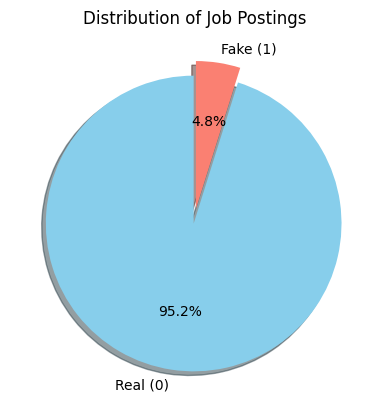

In [12]:
# Count values
print(df['fraudulent'].value_counts())

# Percentage distribution
print("\nClass distribution (in %):")
print(df['fraudulent'].value_counts(normalize=True) * 100)

# Visualize with a pie chart
import matplotlib.pyplot as plt

df['fraudulent'].value_counts().plot.pie(
    labels=['Real (0)', 'Fake (1)'],
    autopct='%1.1f%%',
    colors=['skyblue', 'salmon'],
    startangle=90,
    explode=(0.05, 0.05),
    shadow=True
)
plt.title('Distribution of Job Postings')
plt.ylabel('')
plt.show()


#### Text Vectorization (TF-IDF)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)

# Vectorize the training and test sets
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)


In [14]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample only the training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

# Check balance
print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", pd.Series(y_train_resampled).value_counts())


Before SMOTE:
 fraudulent
0    13611
1      693
Name: count, dtype: int64
After SMOTE:
 fraudulent
0    13611
1    13611
Name: count, dtype: int64


In [15]:
print("X_train_vec shape before SMOTE:", X_train_vec.shape)
print("X_train_resampled shape after SMOTE:", X_train_resampled.shape)

X_train_vec shape before SMOTE: (14304, 92673)
X_train_resampled shape after SMOTE: (27222, 92673)


In [16]:
print("Original class distribution:\n", y_train.value_counts())
print("Resampled class distribution:\n", pd.Series(y_train_resampled).value_counts())

Original class distribution:
 fraudulent
0    13611
1      693
Name: count, dtype: int64
Resampled class distribution:
 fraudulent
0    13611
1    13611
Name: count, dtype: int64


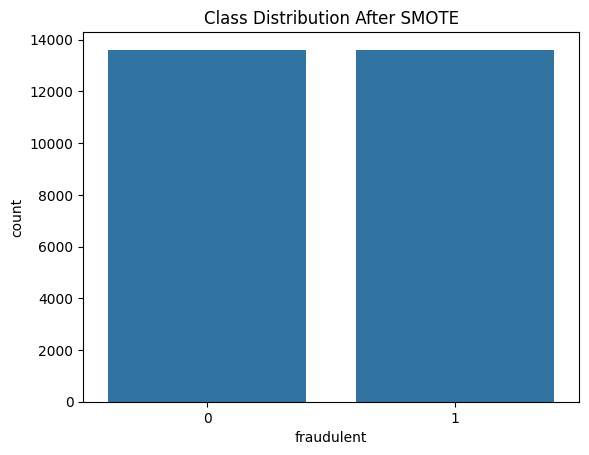

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTE")
plt.show()


## Model Selection & Model Training

###   Logistic Regression

🎯 Accuracy: 0.9874161073825504

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.86      0.88      0.87       173

    accuracy                           0.99      3576
   macro avg       0.93      0.94      0.93      3576
weighted avg       0.99      0.99      0.99      3576



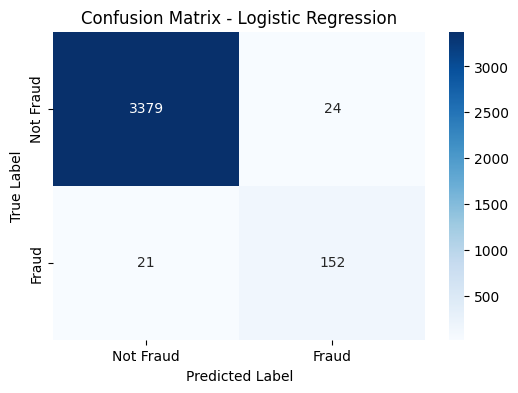

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the model
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the resampled training data
log_reg_model.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred = log_reg_model.predict(X_test_vec)

# Evaluation
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### RandomForestClassifier

🎯 Accuracy: 0.9823825503355704

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       1.00      0.64      0.78       173

    accuracy                           0.98      3576
   macro avg       0.99      0.82      0.88      3576
weighted avg       0.98      0.98      0.98      3576



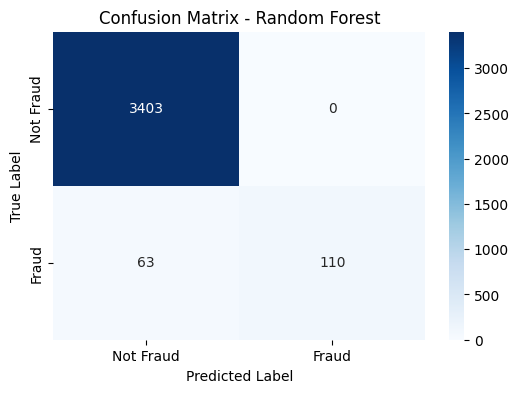

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the resampled training data
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred = rf_model.predict(X_test_vec)

# Evaluation
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### XGBClassifier

🎯 Accuracy: 0.9860178970917226

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.92      0.77      0.84       173

    accuracy                           0.99      3576
   macro avg       0.96      0.89      0.92      3576
weighted avg       0.99      0.99      0.99      3576



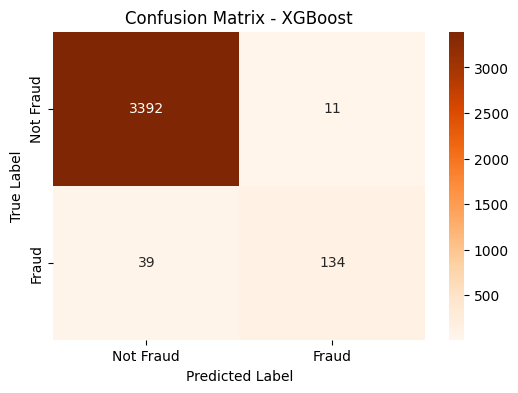

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model on the resampled training data
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
y_pred = xgb_model.predict(X_test_vec)

# Evaluation
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the model
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model on the resampled training data
gb_model.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred = gb_model.predict(X_test_vec)

# Evaluation
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


###  Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the SVM model (you can tweak kernel='linear' or 'rbf' as needed)
svm_model = SVC(kernel='linear', random_state=42)

# Train the model on the resampled training data
svm_model.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred = svm_model.predict(X_test_vec)

# Evaluation
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


###  KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust k if needed

# Train the model on the resampled training data
knn_model.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred = knn_model.predict(X_test_vec)

# Evaluation
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
import joblib

# Save the trained SVM model
joblib.dump(svm_model, 'svm_fake_job_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("✅ SVM model and vectorizer saved successfully! 💾")


In [ ]:
# Essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings('ignore')

# Load and preprocess the data
df = pd.read_csv('fake_job_postings.csv')

# Drop unnecessary columns
df = df.drop(['job_id', 'salary_range'], axis=1)

# Fill missing values in text columns
text_columns = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].fillna('')

# Merge text features into a single column
df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + ' ' + \
             df['company_profile'] + ' ' + df['description'] + ' ' + \
             df['requirements'] + ' ' + df['benefits']

# Split features and target
X = df['text']
y = df['fraudulent']

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Analyze class distribution
print("\nClass distribution:\n", df['fraudulent'].value_counts(normalize=True) * 100)
df['fraudulent'].value_counts().plot.pie(
    labels=['Real (0)', 'Fake (1)'],
    autopct='%1.1f%%',
    colors=['skyblue', 'salmon'],
    startangle=90,
    explode=(0.05, 0.05),
    shadow=True
)
plt.title('Distribution of Job Postings')
plt.ylabel('')
plt.show()

# Text vectorization using TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

# Verify class distribution after resampling
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTE")
plt.show()

# Build and evaluate the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)

# Model prediction and evaluation
y_pred = svm_model.predict(X_test_vec)

print("\n🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()